## Install & Import



In [ ]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf
!apt -qq install cmake

In [ ]:
!pip install gymnasium --quiet
!pip install free-mujoco-py --quiet
!pip install gymnasium[mujoco] --quiet

In [ ]:
import gymnasium as gym
import mujoco_py
import numpy as np
import scipy.ndimage as sm
import matplotlib.pyplot as plt

import pandas as pd
import csv

## Environment Wrapper

In [ ]:
# Classe principale de l'env avec consigne
class SetpointWrapper(gym.Wrapper):
    def __init__(self,
                 config = {
                     "env":'CartPole-v1',
                     "mode":0,
                     "classic":False,
                     "dim":None}):
      self.env = gym.make(config["env"])
      super().__init__(self.env)
      # config
      self._max_episode_steps = self.env._max_episode_steps
      self.mode = config["mode"]  # Mode de l'env
      self.taux_r = 0
      self._elapsed_steps = 0
      self.choice_state(config["dim"])
      self.classic = config['classic']
      self.action_space = self.env.action_space
      # memory
      self.previous_state = None  # Memoire state
      self.previous_action = None # Memoire action
      # observation
      self.define_boundary()
      # define setpoint
      self.set_setpoint()

    ############ Parameter Part
    def signal_generator(self, N, epsilon=0.05):
        a = (1 - 2*epsilon)
        # smoother
        s = np.random.randint(1,N//10)
        # random
        r = np.random.random(N)
        # smooth signal
        smooth = sm.gaussian_filter1d(r, s)
        n = a*(smooth - smooth.min())/(smooth.max() - smooth.min()) + epsilon
        return n

    def define_boundary(self) :
      # explore limit
      i = 0
      cstate = []
      while i < 2*self._max_episode_steps :
        state, _ = self.env.reset()
        cstate += [state[self.chosen_state]]
        terminated = False
        i += 1
        while not(terminated) :
          action = self.env.action_space.sample()
          state, _, terminated, _, _ = self.env.step(action)
          cstate += [state[self.chosen_state]]
          i+=1
      ## calculate boundary
      self.min, self.max = min(cstate), max(cstate)
      self.taux_r = 0.1*(self.max-self.min)
      self.setmin, self.setmax = self.min + self.taux_r, self.max - self.taux_r
      # update min/max
      self.min, self.max = self.min - self.taux_r, self.max + self.taux_r
      ## define observation
      if self.classic :
        n = self.env.observation_space.shape[0]
        low_box, high_box = np.array(n*[-np.inf], dtype=np.float32), np.array(n*[np.inf], dtype=np.float32)
        # update
        low_box[self.chosen_state], high_box[self.chosen_state] = self.min, self.max
      else :
        # our approach
        low_box = np.array([0., self.min, self.min, self.min], dtype=np.float32)
        high_box = np.array([1., self.max, self.max, self.max], dtype=np.float32)
      # set
      self.observation_space = gym.spaces.Box(low=low_box, high=high_box)

    def choice_state(self, dimension=None):
      state_box = self.env.observation_space
      if dimension is None:
          self.chosen_state = np.random.randint(self.env.observation_space.shape[0])
      else :
          self.chosen_state = dimension

    def set_setpoint(self, epsilon=0.05):
        # modes
        if self.mode < 1  :
            self.setpoint = 0
        elif self.mode == 1 :
            self.setpoint = np.random.uniform(self.setmin, self.setmax)
        else :
            consigne = self.signal_generator(self._max_episode_steps+5, epsilon=0.05) # def pour nb max iter
            self.all_setpoint = (self.setmax - self.setmin)*consigne + self.setmin # rescale de  0-1 vers valeurs cibles
            self.setpoint = self.all_setpoint[self._elapsed_steps+1]

    ############ Model Part
    def obs_mode(self, state, init=False):
      # classic, Constant or setpoint
      if self.mode == 2 :
        self.setpoint = self.all_setpoint[self._elapsed_steps+1]
      if init :
        self.previous_state = state[self.chosen_state]
        self.previous_action = self.action_space.sample()
      obs = np.array([self.previous_action, state[self.chosen_state], self.previous_state, self.setpoint])
      self.previous_state = state[self.chosen_state]
      return obs

    ############ Simulation Part
    def reset(self, seed=None, options=None):
      state, _ = self.env.reset()
      self._elapsed_steps = 0 # reset steps
      self.set_setpoint() # reset setpoint
      if self.classic:
        obs = state
      else : obs = self.obs_mode(state, init=True)
      return obs, {}

    def step(self, action):
      self._elapsed_steps+=1
      state, reward, terminated, truncated, info = self.env.step(action)
      if self.classic:
        obs = state
      else : obs = self.obs_mode(state)
      self.previous_action = action
      # mode -1
      pos_pole = state[self.chosen_state]
      # terminated
      if self.mode>-1 :
        terminated = (pos_pole < self.setmin-self.taux_r or pos_pole > self.setmax+self.taux_r)
        if self.setpoint-self.taux_r > pos_pole or pos_pole > self.setpoint + self.taux_r:
          reward = 0.1
        else : reward = 1.
      else : terminated = (pos_pole < self.setmin or pos_pole > self.setmax)
      return obs, reward, terminated, truncated, info

## Testing if generalized

In [ ]:
config = {"env":'Acrobot-v1', "mode":0, "classic":True, "dim":None}
config = {"env":'Humanoid-v4', "mode":0, "classic":True, "dim":None}

251 -8.590215818747861 8.602795140739167
999 (1001, 376)


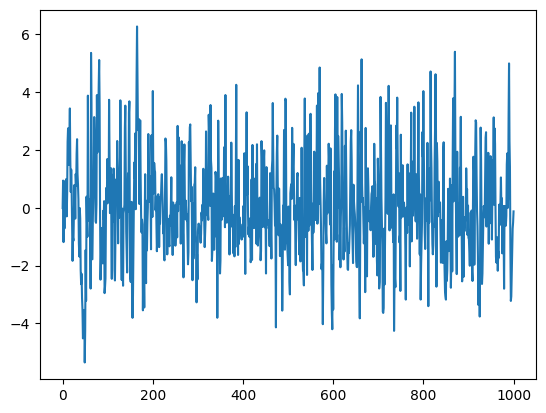

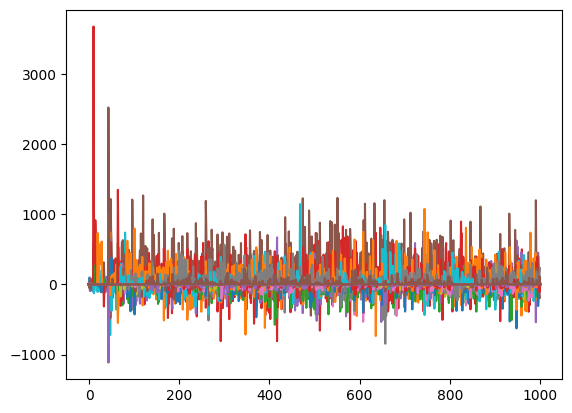

In [ ]:
env = SetpointWrapper(config)
print(env.chosen_state, env.min, env.max)
# init
state, _ = env.reset()
state_ = [state]
for i in range(env._max_episode_steps) :
  action = env.action_space.sample()
  state, reward, terminated, truncated, info = env.step(action)
  # update
  state_ += [state]
  if terminated : break
state_ = np.array(state_)
print(i, state_.shape)
plt.plot(state_[:,env.chosen_state]); plt.show()
plt.plot(state_); plt.show()